In [2]:
# Import the modules
import numpy
import numpy as np
import pandas as pd
from pathlib import Path
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import RandomizedSearchCV as RSCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt 
%matplotlib inline
import csv
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Read the CSV file from the Resources folder into a Pandas DataFrame
log_reg_df = pd.read_csv("Resources/analysis_df.csv")

# Reshuffling the data for good measure
log_reg_df = log_reg_df.sample(frac = 1)

In [4]:
# Checkpoint
log_reg_df.shape

(150001, 6)

In [5]:
# Review the DataFrame
log_reg_df.head().append(log_reg_df.tail())

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,ORIGIN,DEP_DEL15
4591,11,13,Sunday,Republic Airline,DCA,0
83503,8,3,Thursday,Southwest Airlines,HOU,0
23093,11,28,Monday,American Airlines,BOS,0
142862,11,15,Tuesday,Southwest Airlines,MCO,0
67246,11,4,Friday,Endeavor Air,LGA,1
60478,8,29,Tuesday,United Air Lines,LGA,0
33527,7,7,Friday,Spirit Air Lines,ORD,1
24760,3,12,Sunday,JetBlue Airways,JFK,1
52286,10,6,Thursday,United Air Lines,AUS,0
43455,11,21,Monday,Southwest Airlines,AUS,1


### Column Definitions

* YEAR = Year of Flight
* MONTH = Month of Flight
* DAY_OF_MONTH = Day of Month
* DAY_OF_WEEK = Day of Week
* OP_CARRIER = Carrier Name
* ORIGIN = Origin Airport Code
* DEP_DEL15 = Departure Delay (0 = No, 1 = Yes)

In [6]:
# Changing data type to string to address regression analysis errors
log_reg_df = log_reg_df.astype(str)

In [7]:
# Checkpoint
log_reg_df['ORIGIN'].value_counts()

ATL    7529
DEN    6431
DFW    6121
ORD    5738
CLT    4270
       ... 
ROW      21
MHK      20
TXK      19
DEC      18
MVY      18
Name: ORIGIN, Length: 241, dtype: int64

In [8]:
# Removing airports with fewer than 1000 flights
origin_adjust = log_reg_df['ORIGIN'].value_counts()

to_remove = origin_adjust[origin_adjust <= 1000].index

log_reg_adjust = log_reg_df[~log_reg_df.ORIGIN.isin(to_remove)]

# Checkpoint
log_reg_adjust['ORIGIN'].value_counts()

ATL    7529
DEN    6431
DFW    6121
ORD    5738
CLT    4270
LAX    4165
LAS    4155
SEA    3871
PHX    3822
LGA    3676
MCO    3575
DCA    3225
BOS    3142
JFK    3088
EWR    3038
SFO    2922
MSP    2821
DTW    2670
IAH    2599
MIA    2318
SLC    2316
BWI    2117
SAN    2107
BNA    2106
AUS    2050
FLL    1989
PHL    1971
MDW    1878
TPA    1606
DAL    1570
HNL    1358
STL    1351
PDX    1282
SJC    1259
RDU    1219
SMF    1199
HOU    1165
IAD    1152
MSY    1125
SNA    1040
MCI    1036
OAK    1030
Name: ORIGIN, dtype: int64

In [9]:
# Checkpoint
log_reg_adjust.shape

(113102, 6)

In [10]:
# Transforming the data using get_dummies
month_dummies = pd.get_dummies(log_reg_adjust["MONTH"])
day_dummies = pd.get_dummies(log_reg_adjust["DAY_OF_WEEK"])
carrier_dummies = pd.get_dummies(log_reg_adjust["OP_CARRIER"])
origin_dummies = pd.get_dummies(log_reg_adjust["ORIGIN"])

In [11]:
# Display the transformed data
month_dummies.tail()
#day_dummies.tail()
#carrier_dummies.tail()
#origin_dummies.tail()

,1,10,11,12,2,3,4,5,6,7,8,9
60478,0,0,0,0,0,0,0,0,0,0,1,0
33527,0,0,0,0,0,0,0,0,0,1,0,0
24760,0,0,0,0,0,1,0,0,0,0,0,0
52286,0,1,0,0,0,0,0,0,0,0,0,0
43455,0,0,1,0,0,0,0,0,0,0,0,0


In [12]:
# Concatenate log_reg_adjust and the created dummies DataFrames
dummy_df = pd.concat([log_reg_adjust, 
                                  month_dummies, 
                                  day_dummies,
                                  carrier_dummies,
                                  origin_dummies,
                                 ], 
                                 axis=1)

# Drop the originating dummies columns
tranformed_logreg_df = dummy_df.drop(columns=["MONTH",
                                                "4",
                                                "DAY_OF_MONTH",
                                                "DAY_OF_WEEK", 
                                                "Saturday",
                                                "OP_CARRIER",
                                                "Alaska Airlines", 
                                                "ORIGIN", 
                                             ])

# Display the DataFrame
tranformed_logreg_df.head()

,DEP_DEL15,1,10,11,12,2,3,5,6,7,...,RDU,SAN,SEA,SFO,SJC,SLC,SMF,SNA,STL,TPA
4591,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83503,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23093,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
142862,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67246,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Logistical Regression

In [13]:
# Separate the data into labels and features

# Separate the y variable, the labels
y = tranformed_logreg_df['DEP_DEL15']

# Separate the X variable, the features
X = tranformed_logreg_df.drop(columns=['DEP_DEL15'])

In [14]:
# Review the y variable Series
y.head().append(y.tail())

4591      0
83503     0
23093     0
142862    0
67246     1
60478     0
33527     1
24760     1
52286     0
43455     1
Name: DEP_DEL15, dtype: object

In [15]:
# Check the balance of our target values
y.value_counts()

0    87185
1    25917
Name: DEP_DEL15, dtype: int64

In [16]:
# Review the X variable DataFrame
X.head().append(X.tail())

,1,10,11,12,2,3,5,6,7,8,...,RDU,SAN,SEA,SFO,SJC,SLC,SMF,SNA,STL,TPA
4591,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83503,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
23093,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
142862,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67246,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60478,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
33527,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
24760,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52286,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43455,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# Import the train_test_learn module
from sklearn.model_selection import train_test_split

# Split the data using train_test_split
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [18]:
# Import the LogisticRegression module from SKLearn
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
logistic_regression_model = LogisticRegression(random_state=1, penalty = 'l2')

# Fit the model using training data
lr_model = logistic_regression_model.fit(X_train, y_train)

In [19]:
# Make a prediction using the testing data
testing_predictions = logistic_regression_model.predict(X_test)

In [20]:
# Print the balanced_accuracy score of the model
acc_score = balanced_accuracy_score(y_test, testing_predictions)
acc_score

0.5003732536184096

In [21]:
# Generate a confusion matrix for the model
cm = confusion_matrix(y_test, testing_predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual On Time", "Actual Delay"], columns=["Predicted On Time", "Predicted Delay"]
)

In [22]:
# Print the classification report for the model
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, testing_predictions))

Confusion Matrix


,Predicted On Time,Predicted Delay
Actual On Time,21819,4
Actual Delay,6447,6


Accuracy Score : 0.5003732536184096
Classification Report
              precision    recall  f1-score   support

           0       0.77      1.00      0.87     21823
           1       0.60      0.00      0.00      6453

    accuracy                           0.77     28276
   macro avg       0.69      0.50      0.44     28276
weighted avg       0.73      0.77      0.67     28276



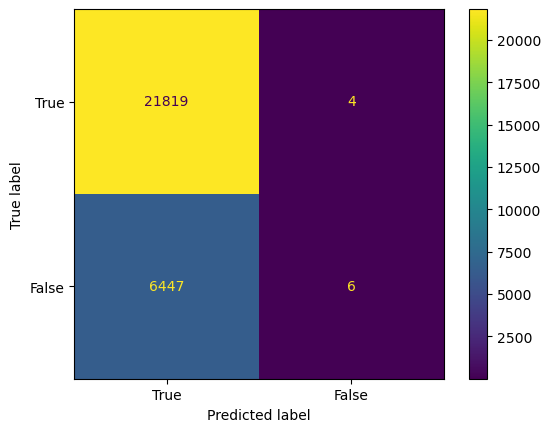

In [23]:
#Alternate Confusion Matrix display
confusion_matrix_alternate = metrics.confusion_matrix(y_test, testing_predictions)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_alternate, display_labels = [True, False])

cm_display.plot()
plt.show() 

## Logistical Regression: Random OverSampler

In [24]:
# Using the RandomOverSampler module to resample the data 

# Instantiate the random oversampler model
# # Assign a random_state parameter of 1 to the model
ros = RandomOverSampler(random_state=1)

# Fit the original training data to the random_oversampler model
X_res, y_res = ros.fit_resample(X_train, y_train)

In [25]:
# Count the distinct values of the resampled labels data
y_res.value_counts()

1    65362
0    65362
Name: DEP_DEL15, dtype: int64

In [26]:
# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
logistic_regression_model_resampled = LogisticRegression(random_state=1)

# Fit the model using the resampled training data
resampled_lr_model = logistic_regression_model_resampled.fit(X_res, y_res)

# Make a prediction using the testing data
retesting_predictions = logistic_regression_model_resampled.predict(X_res)

In [27]:
# Print the balanced_accuracy score of the model 
acc_rescore = balanced_accuracy_score(y_res, retesting_predictions)
acc_rescore

0.5900676233897372

In [28]:
# Generate a confusion matrix for the model
cm2 = confusion_matrix(y_res, retesting_predictions)
cm2_df = pd.DataFrame(
    cm2, index=["Actual On Time (OS)", "Actual Delay (OS)"], columns=["Predicted On Time (OS)", "Predicted Delay (OS)"]
)

In [29]:
# Print the classification report for the model
print("Resampled Confusion Matrix")
display(cm2_df)
print(f"Accuracy Score : {acc_rescore}")
print("Classification Report")
print(classification_report(y_res, retesting_predictions))

Resampled Confusion Matrix


,Predicted On Time (OS),Predicted Delay (OS)
Actual On Time (OS),38273,27089
Actual Delay (OS),26499,38863


Accuracy Score : 0.5900676233897372
Classification Report
              precision    recall  f1-score   support

           0       0.59      0.59      0.59     65362
           1       0.59      0.59      0.59     65362

    accuracy                           0.59    130724
   macro avg       0.59      0.59      0.59    130724
weighted avg       0.59      0.59      0.59    130724



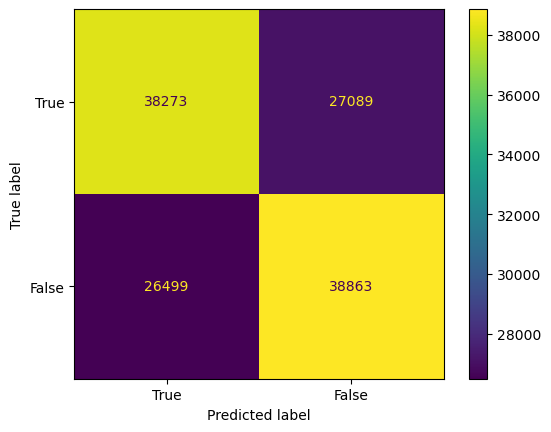

In [30]:
#Alternate Confusion Matrix display
confusion_matrix_oversample = metrics.confusion_matrix(y_res, retesting_predictions)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_oversample, display_labels = [True, False])

cm_display.plot()
plt.show() 

## Random Forest

In [31]:
# Loading data
forest_df = tranformed_logreg_df.sample(frac = 1)
forest_df.head()

,DEP_DEL15,1,10,11,12,2,3,5,6,7,...,RDU,SAN,SEA,SFO,SJC,SLC,SMF,SNA,STL,TPA
133955,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
129634,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63467,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89522,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
88517,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# Define features set
X = forest_df.copy()
X.drop("DEP_DEL15", axis=1, inplace=True)
X.head()

,1,10,11,12,2,3,5,6,7,8,...,RDU,SAN,SEA,SFO,SJC,SLC,SMF,SNA,STL,TPA
133955,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
129634,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63467,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89522,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
88517,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# Define target vector
y = forest_df["DEP_DEL15"].ravel()
y[:5]

array(['0', '0', '0', '0', '0'], dtype=object)

In [34]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [35]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [36]:
# Fit the model using training data
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=78)

In [37]:
# Making predictions using the testing data
rf_predictions = rf_model.predict(X_test)

In [38]:
# Calculating the confusion matrix
rf_cm = confusion_matrix(y_test, rf_predictions)
rf_cm_df = pd.DataFrame(
    rf_cm, index=["Actual On Time", "Actual Delay"], columns=["Predicted On Time", "Predicted Delay"]
)

# Calculating the accuracy score
rf_acc_score = accuracy_score(y_test, rf_predictions)

In [39]:
# Displaying results
print("Confusion Matrix")
display(rf_cm_df)
print(f"Accuracy Score : {rf_acc_score}")
print("Classification Report")
print(classification_report(y_test, rf_predictions))

Confusion Matrix


,Predicted On Time,Predicted Delay
Actual On Time,20137,1623
Actual Delay,5707,809


Accuracy Score : 0.740769557221672
Classification Report
              precision    recall  f1-score   support

           0       0.78      0.93      0.85     21760
           1       0.33      0.12      0.18      6516

    accuracy                           0.74     28276
   macro avg       0.56      0.52      0.51     28276
weighted avg       0.68      0.74      0.69     28276



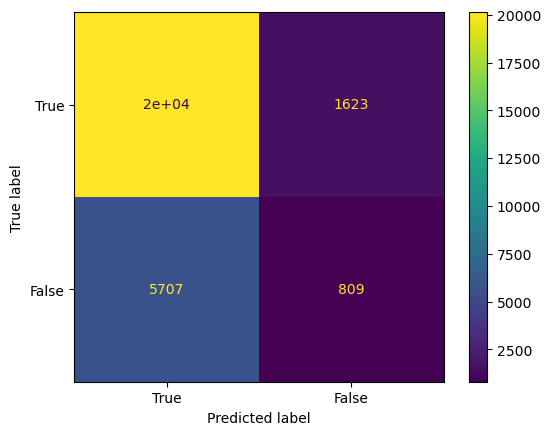

In [41]:
#Alternate Confusion Matrix display
confusion_matrix_rf = metrics.confusion_matrix(y_test, rf_predictions)

cm3_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_rf, display_labels = [True, False])

cm3_display.plot()
plt.show() 

In [42]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_

# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.048455909278717534, 'Thursday'),
 (0.04808624536466191, 'Monday'),
 (0.04753127443292215, 'Wednesday'),
 (0.0443614162858601, 'Sunday'),
 (0.04077129995305429, 'Friday'),
 (0.033213171813513374, 'Tuesday'),
 (0.026781467681719694, '3'),
 (0.025416249921412653, '8'),
 (0.024481848853487583, '1'),
 (0.01980031083540192, 'United Air Lines'),
 (0.019710266679818265, '2'),
 (0.019554948319225628, '5'),
 (0.019343842368560262, 'American Airlines'),
 (0.01712097043468439, '11'),
 (0.016120630097118886, 'Delta Air Lines'),
 (0.01584260086031873, 'Southwest Airlines'),
 (0.015147447536769438, '9'),
 (0.015113398461276614, '6'),
 (0.015057187239870993, '12'),
 (0.014895887681226494, '7'),
 (0.014611868825714835, 'ATL'),
 (0.013587362601720436, '10'),
 (0.013431746420836804, 'LGA'),
 (0.013348162580886815, 'LAX'),
 (0.013272552643458363, 'ORD'),
 (0.012469518057071858, 'MCO'),
 (0.012221779364074098, 'BOS'),
 (0.01218301511025463, 'LAS'),
 (0.011632875236906879, 'PHX'),
 (0.011556101475294981

<Axes: title={'center': 'Top 10 Features Importances'}, ylabel='1'>

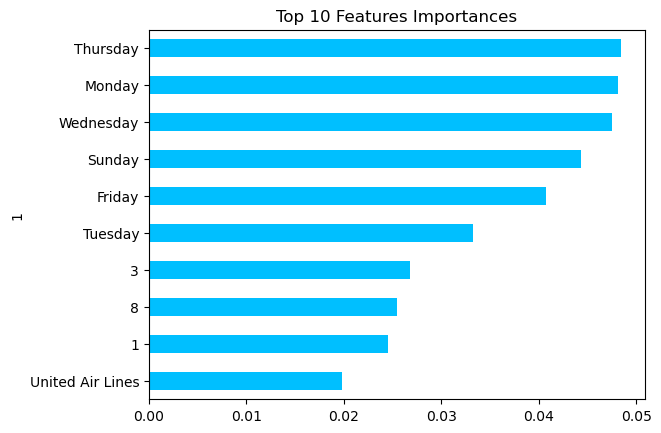

In [43]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df[:10].sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='deepskyblue', title= 'Top 10 Features Importances', legend=False)

## Random Forest: Best Estimator

In [44]:
# Creating the random forest Best Estimator
param_grid = {'n_estimators':np.arange(50,200,15),
              'max_features':np.arange(0.1, 1, 0.1),
              'max_depth': [3, 5, 7, 9],
              'max_samples': [0.3, 0.5, 0.8]}

rf2_model = RSCV(RandomForestClassifier(), param_grid, n_iter = 15).fit(X_train, y_train)
rf2_model_result = rf2_model.best_estimator_
rf2_model_result

RandomForestClassifier(max_depth=7, max_features=0.7000000000000001,
                       max_samples=0.8, n_estimators=185)

In [45]:
# Making predictions using the testing data
rf2_predictions = rf2_model.predict(X_test)

In [46]:
# Calculating the confusion matrix
rf2_cm = confusion_matrix(y_test, rf_predictions)
rf2_cm_df = pd.DataFrame(
    rf2_cm, index=["Actual On Time", "Actual Delay"], columns=["Predicted On Time", "Predicted Delay"]
)

# Calculating the accuracy score
rf2_acc_score = accuracy_score(y_test, rf2_predictions)

In [47]:
# Displaying results
print("Confusion Matrix")
display(rf_cm_df)
print(f"Accuracy Score : {rf2_acc_score}")
print("Classification Report")
print(classification_report(y_test, rf2_predictions))

Confusion Matrix


,Predicted On Time,Predicted Delay
Actual On Time,20137,1623
Actual Delay,5707,809


Accuracy Score : 0.7700523412080916
Classification Report
              precision    recall  f1-score   support

           0       0.77      1.00      0.87     21760
           1       0.62      0.01      0.01      6516

    accuracy                           0.77     28276
   macro avg       0.70      0.50      0.44     28276
weighted avg       0.74      0.77      0.67     28276



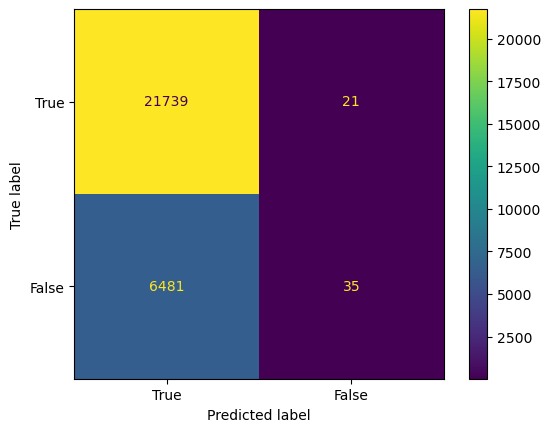

In [48]:
#Alternate Confusion Matrix display
confusion_matrix_rfbe = metrics.confusion_matrix(y_test, rf2_predictions)

cm4_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_rfbe, display_labels = [True, False])

cm4_display.plot()
plt.show() 

In [49]:
# Random Forests in sklearn will automatically calculate feature importance
importances2 = rf2_model.best_estimator_.feature_importances_

# We can sort the features by their importance
sorted(zip(rf2_model.best_estimator_.feature_importances_, X.columns), reverse=True)

[(0.14963126350905892, 'Southwest Airlines'),
 (0.09891263617278738, 'Frontier Airlines'),
 (0.09472633909908448, 'JetBlue Airways'),
 (0.09222094378890723, '7'),
 (0.05599043484416264, '6'),
 (0.04113962817556264, 'Spirit Air Lines'),
 (0.03816004840464052, '12'),
 (0.03371763791642704, 'SkyWest Airlines'),
 (0.02426696956616718, 'American Airlines'),
 (0.02201642944744327, 'DEN'),
 (0.021154817389594318, 'BWI'),
 (0.01972157793494725, '2'),
 (0.016652221708388287, 'Friday'),
 (0.01538893715853794, '10'),
 (0.015313043992517143, 'Wednesday'),
 (0.015011764721609729, 'Tuesday'),
 (0.014442203697885929, 'MCO'),
 (0.014434312795727756, 'DFW'),
 (0.013659272830702875, '9'),
 (0.01299724941668325, 'LAS'),
 (0.012889050688273465, 'Monday'),
 (0.012165206786035842, 'Thursday'),
 (0.011536250713990098, 'Sunday'),
 (0.010375351084335838, 'EWR'),
 (0.009055712306888146, '1'),
 (0.008220665806895655, '8'),
 (0.007795967016480599, 'United Air Lines'),
 (0.006632223667145624, 'ATL'),
 (0.006221769

<Axes: title={'center': 'Top 10 Features Importances'}, ylabel='1'>

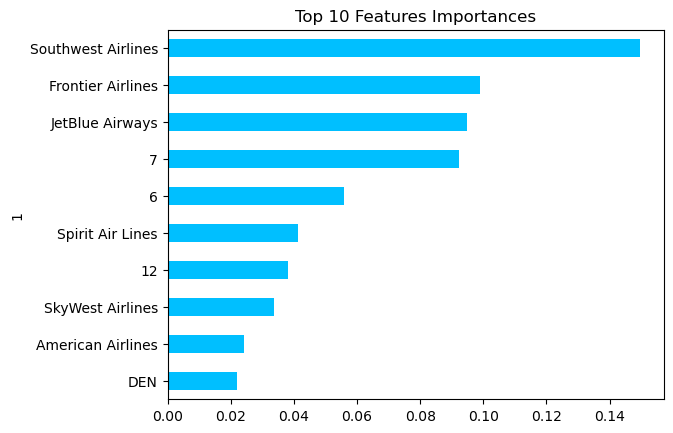

In [50]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf2_model.best_estimator_.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df[:10].sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='deepskyblue', title= 'Top 10 Features Importances', legend=False)

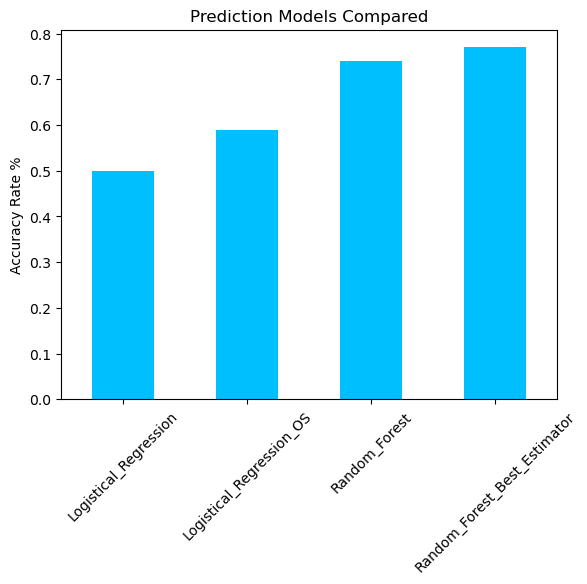

In [51]:
# Plotting the prediction models to compare accuracy
model_comparison = pd.DataFrame({0.50, 0.59, 0.74, 0.77},
    index=["Logistical_Regression", "Logistical_Regression_OS", "Random_Forest", "Random_Forest_Best_Estimator"])

model_comparison.plot(kind='bar', color ='deepskyblue', legend=None)
plt.xticks(rotation=45)
plt.ylabel("Accuracy Rate %")
plt.title("Prediction Models Compared")
plt.show()